In [1]:
from os import walk
from os.path import join
from typing import List, Tuple, Callable
from statistics import mean, stdev
from math import isclose

from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
def ingest_pid(pid_filename: str, traffic: bool, speed_limit: int, lr: bool):
    df: pd.DataFrame = pd.read_csv(pid_filename) # type: ignore
    # Drop the first row due to initialization movement.
    df.drop(index=df.index[0:5], axis=0, inplace=True) # type:ignore

    key_coords: List[float] = []
    coord_is_x: List[bool] = [False, False, False, True, True, True, True, False, False, False]
    use_gt: List[bool] = [True, True, True, True, True, True, True, True, True, True]

    # Progression order is dependent on lr variable.
    #   1. straight
    #   2. left or right
    #   3. straight
    #   4. right or left
    #   5. straight
    # Both start in the same place but start deviating at the 2nd intersection.

    # 1st int: straight
    # start: Lead Vehicle y axis value > -4374.36
    # end: Driver y axis value > -4205.00
    key_coords.append(-4374.36)
    key_coords.append(-4205.00)

    if lr:
        # straight, left, straight, right, straight
        use_gt[3:7] = [False, False, False, False]

        # 2nd int: left
        # start: Lead Vehicle y axis value > -1074.42
        # end: Driver x axis value < -2395.39
        key_coords.append(-1074.42)
        key_coords.append(-2395.39)

        # 3rd int: straight
        # start: Lead Vehicle x axis value < -5525.84
        # end: Driver x axis value < -5695.27
        key_coords.append(-5525.84)
        key_coords.append(-5695.27)

        # 4th int: right
        # start: Lead Vehicle x axis value < -8825.73
        # end: Driver y axis value > -904.95
        key_coords.append(-8825.73)
        key_coords.append(-904.95)

    else:
        # 2nd int: right
        # start: Lead Vehicle y axis value > -1074.42
        # end: Driver x axis value > -8825.60
        key_coords.append(-1074.42)
        key_coords.append(-8825.60)

        # 3rd int: straight
        # start: Lead Vehicle x axis value > -5695.27
        # end: Driver x axis value > -5525.84
        key_coords.append(-5695.27)
        key_coords.append(-5525.84)

        # 4th int: left
        # start: Lead Vehicle x axis value > -2395.00
        # end: Driver y axis value > -904.95
        key_coords.append(-2395.00)
        key_coords.append(-904.95)

    # 5th int: straight
    # start: Lead Vehicle y axis value > 2225.55
    # end: Driver y axis value > 2395.23
    key_coords.append(2225.55)
    key_coords.append(2395.23)
    
    assert len(key_coords) == len(coord_is_x) == 5*2
    assert len(key_coords)%2 == 0

    ok = 0
    lefts = []
    rights = []
    throughs = []

    # Gather intersection entrance and exit times for both vehicles
    for i in range(5):

        is_ok = False

        if i==1:
            move = 'L' if lr else 'R'
        elif i==3:
            move = 'R' if lr else 'L'
        else:
            move = str(i+1)

        i *= 2

        #         Lead Vehicle;     Driver
        # x axis: SCC_DynObj_Pos_0; VDS_Chassis_CG_Position_1
        # y axis: SCC_DynObj_Pos_1; VDS_Chassis_CG_Position_0
        if use_gt[i]:
            lead_enter_filter = df[f'SCC_DynObj_Pos_{int(not coord_is_x[i])}'] > key_coords[i]
            driver_enter_filter = df[f'VDS_Chassis_CG_Position_{int(coord_is_x[i])}'] > key_coords[i]
        else:
            lead_enter_filter = df[f'SCC_DynObj_Pos_{int(not coord_is_x[i])}'] < key_coords[i]
            driver_enter_filter = df[f'VDS_Chassis_CG_Position_{int(coord_is_x[i])}'] < key_coords[i]
        
        if use_gt[i+1]:
            lead_exit_filter = df[f'SCC_DynObj_Pos_{int(not coord_is_x[i+1])}'] > key_coords[i+1]
            driver_exit_filter = df[f'VDS_Chassis_CG_Position_{int(coord_is_x[i+1])}'] > key_coords[i+1]
        else:
            lead_exit_filter = df[f'SCC_DynObj_Pos_{int(not coord_is_x[i+1])}'] < key_coords[i+1]
            driver_exit_filter = df[f'VDS_Chassis_CG_Position_{int(coord_is_x[i+1])}'] < key_coords[i+1]


        try:
            # a is leader rows
            a = df[(df[lead_enter_filter]['timestamp'].iloc[0] <= df['timestamp']) &  # type: ignore
                (df['timestamp'] <= df[lead_exit_filter]['timestamp'].iloc[0])]  # type: ignore
            
            # b is driver rows
            b = df[(df[driver_enter_filter]['timestamp'].iloc[0] <= df['timestamp']) &  # type: ignore
                (df['timestamp'] <= df[driver_exit_filter]['timestamp'].iloc[0])]  # type: ignore
        except IndexError:
            print(f'IndexError: {move} {pid_filename}\n')
            continue

        if (a.shape[0] < 2) or (b.shape[0] < 2):  # type: ignore
            print(f'Too small: {move} {pid_filename}')
        elif (a.shape[0] > 1000) or (a.shape[0] > 1000):  # type: ignore
            print(f'Too large: {move} {pid_filename}')
        elif abs(a.shape[0]-b.shape[0]) > 100:  # type: ignore
            print(f'Large diff: {move} {pid_filename}')
        else:
            ok += 1
            is_ok = True

        if is_ok:

            df_leader = a[['timestamp', 'SCC_DynObj_Pos_0', 'SCC_DynObj_Pos_1', 'VDS_Chassis_CG_Position_1', 'VDS_Chassis_CG_Position_0']].copy()
            df_leader.rename(columns={'SCC_DynObj_Pos_0': 'x', 'SCC_DynObj_Pos_1': 'y', 'VDS_Chassis_CG_Position_1': 'driver_x', 'VDS_Chassis_CG_Position_0': 'driver_y'}, inplace=True)
            df_driver = b[['timestamp', 'VDS_Chassis_CG_Position_1', 'VDS_Chassis_CG_Position_0', 'SCC_DynObj_Pos_0', 'SCC_DynObj_Pos_1']].copy()
            df_driver.rename(columns={'VDS_Chassis_CG_Position_1': 'x', 'VDS_Chassis_CG_Position_0': 'y', 'SCC_DynObj_Pos_0': 'lead_x', 'SCC_DynObj_Pos_1': 'lead_y'}, inplace=True)
            
            if move == 'L':
                lefts.append((df_leader, df_driver))
            elif move == 'R':
                rights.append((df_leader, df_driver))
            else:
                throughs.append((df_leader, df_driver))

        else:
            print(df.shape, a.shape, b.shape)
            # print([df[lead_enter_filter]['timestamp'].iloc[0], df[lead_exit_filter]['timestamp'].iloc[0]])
            # print((df[driver_enter_filter]['timestamp'].iloc[0], df[driver_exit_filter]['timestamp'].iloc[0]))
            print('')

    return ok, lefts, rights, throughs

ok = 0
count = 0
lefts = []
rights = []
throughs = []

for root, _, files in walk("./data"):
    for name in files:
        pid = int(root[-2:])
        if pid in {1, 2, 3, 4, 7}:
            continue
        if name.endswith(".csv"):
            # Check yes/no
            traffic = name[8:10] == "YE"
            try:
                speed_limit = int(name[10+traffic:12+traffic])
            except ValueError:
                # print('ERROR:', name)
                continue
            lr = name[13+traffic:15+traffic] == 'LR'
            try:
                oks, new_lefts, new_rights, new_throughs, = ingest_pid(join(root, name), traffic, speed_limit, lr)
                ok += oks
                lefts += new_lefts
                rights += new_rights
                throughs += new_throughs
                count += 5
            except IndexError:
                print('IndexError:', join(root, name))
                break

print(ok/count)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/carlin/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_6141/4051180956.py", line 161, in <module>
    for root, _, files in walk("./data"):
NameError: name 'walk' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/carlin/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/carlin/miniconda3/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/c

TypeError: object of type 'NoneType' has no len()

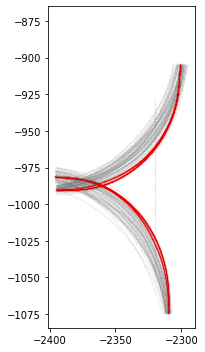

In [16]:
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    

def plot_movement(movement, focus: int = 0, save_filename = None, title = None, figsize: float = 5):

    fig = plt.figure(num=1)
    ax = fig.add_subplot(111)
    x_max = None
    y_max = None
    x_min = None
    y_min = None
    for df in movement:
        if focus > 0:
            # focus lead vehicle plot
            x_lead = df[0]['x']
            y_lead = df[0]['y']
            x_driver = df[0]['driver_x']
            y_driver = df[0]['driver_y']
        elif focus == 0:
            # equal focus
            x_lead = df[0]['x']
            y_lead = df[0]['y']
            x_driver = df[1]['x']
            y_driver = df[1]['y']
        elif focus < 0:
            # focus lead vehicle plot
            x_lead = df[1]['lead_x']
            y_lead = df[1]['lead_y']
            x_driver = df[1]['x']
            y_driver = df[1]['y']
        ax.scatter(x_lead, y_lead, c='r', alpha=.1, s=.1)
        ax.scatter(x_driver, y_driver, c='gray', alpha=.1, s=.2)

        x_max_this = max(x_lead.max(), x_driver.max())
        if x_max is None or x_max_this > x_max:
            x_max = x_max_this
        x_min_this = max(x_lead.min(), x_driver.min())
        if x_min is None or x_min_this > x_min:
            x_min = x_min_this
        y_max_this = max(y_lead.max(), y_driver.max())
        if y_max is None or y_max_this > y_max:
            y_max = y_max_this
        y_min_this = max(y_lead.min(), y_driver.min())
        if y_min is None or y_min_this > y_min:
            y_min = y_min_this
    
    dx = abs(x_max-x_min)
    dy = abs(y_max-y_min)
    ax.set_aspect(dy/dx)
    if dx > dy:
        fig.set_figwidth(figsize)
        fig.set_figheight(figsize * dy/dx)
    else:
        fig.set_figwidth(figsize * dx/dy)
        fig.set_figheight(figsize)

    if title:
        ax.set_title(title)
    plt.tight_layout()
    if save_filename:
        plt.savefig(save_filename)

    plt.show()

plot_movement(lefts, 0, 'charts/lefts_all.png')

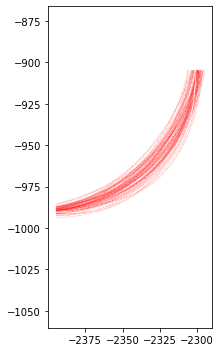

In [4]:
lefts_upper = []
lefts_lower = []
for df in lefts:
    if df[0]['y'].max() > -905:
        lefts_upper.append(df)
    elif df[0]['y'].min() < -1070:
        lefts_lower.append(df)

plot_movement(lefts_upper)

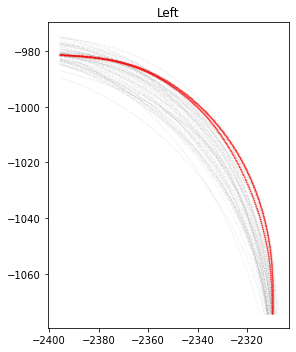

In [17]:
plot_movement(lefts_lower, 0, 'charts/lefts.png', 'Left')

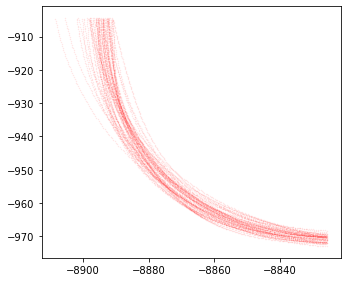

In [6]:
rights_upper = []
rights_lower = []
for df in rights:
    if df[0]['y'].max() > -905:
        rights_upper.append(df)
    elif df[0]['y'].min() < -1070:
        rights_lower.append(df)

plot_movement(rights_upper)

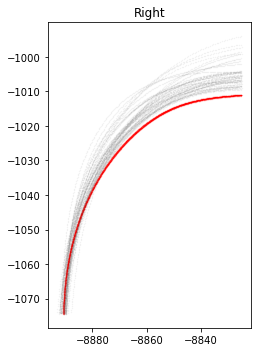

In [18]:
plot_movement(rights_lower, 0, 'charts/rights.png', 'Right')

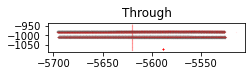

In [19]:
through_up_left = []
through_up_right = []
through_down_left = []
through_down_right = []
through_mid = []
for df in throughs:
    if df[0]['y'].max() > 0:
        if df[0]['x'].max() < -8000:
            through_up_left.append(df)
        else:
            through_up_right.append(df)
    elif df[0]['y'].min() < -3000:
        if df[0]['x'].max() < -8000:
            through_down_left.append(df)
        else:
            through_down_right.append(df)
    else:
        through_mid.append(df)

# for movement in [through_up_left, through_up_right, through_down_left, through_down_right]:
#     plot_movement(movement)

plot_movement(through_mid, 0, 'charts/through.png', 'Through')

/tmp/ipykernel_21062/3338431437.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


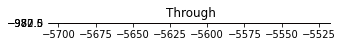

In [9]:
through_mid_up = []
through_mid_down = []
for df in through_mid:
    if all(df[0]['y'] > -990):
        through_mid_up.append(df)
    elif all(df[0]['y'] < -990):
        through_mid_down.append(df)

plot_movement(through_mid_up, 0, 'charts/through_mid_up.png', 'Through')

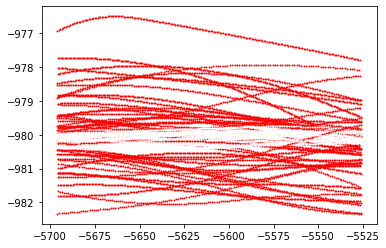

(-0.00031897208421246236,
 0.007400314415132073,
 0.9290283519292644,
 0.09400198174589326)

In [10]:
# fit bezier curve
def create_sample(movement):
    # only works for movements that go from bottom to left

    deltas = []
    t_scalings = []

    for dfs in movement:

        lead_x = None
        lead_y = None
        m = None
        b = None
        dx = None
        dy = None

        driver_x = None
        driver_y = None
        
        lead_td = None
        driver_td = None

        length = None
        
        # Set bezier curve start and end points to be the lead vehicle's

        for i,df in enumerate(dfs):

            df.sort_values('x', inplace=True, ascending=False)

            x_start = df['x'].max()
            y_start = df['y'].min()

            # x_end = dfs[0]['x'].min()
            # y_end = dfs[0]['y'].max()

            length = 0
            last_x = x_start
            last_y = y_start
            for _,row in df.iterrows():
                next_x = row['x']
                next_y = row['y']
                length += ((next_x-last_x)**2 + (next_y-last_y)**2)**.5
                last_x = next_x
                last_y = next_y
            
            length2 = 0
            last_x = x_start
            last_y = y_start
            for _,row in df.iterrows():
                next_x = row['x']
                next_y = row['y']
                length2 += ((next_x-last_x)**2 + (next_y-last_y)**2)**.5
                if length2/length > .5:
                    break
                last_x = next_x
                last_y = next_y
            x_mid = next_x
            y_mid = next_y                    

            plt.scatter(df['x'], df['y'], s=1, c='white' if i==0 else 'r', alpha=.9)

            # Search for a good control point in a 10x10 square around the midpoint
            # create a formula and find the control point with lowest least squares

            # def curve_of_x(x_control) -> Callable[[float], float]:
            #     def curve_x(p) -> float:
            #         return (1-p)*((1-p)*x_start+p*x_control) + p*((1-p)*x_control+p*x_end)
            
            # def curve_of_x(x_control) -> Callable[[float], float]:
            #     def curve_y(p) -> float:
            #         return (1-p)*((1-p)*y_start+p*y_control) + p*((1-p)*y_control+p*y_end)

            # x_control_best = None
            # y_control_best = None
            # for i in range(10):
            #     for j in range(10):
            #         x_control = x_start - i
            #         y_control = y_end - j
            
            # ps = [p/1000 for p in range(1000)]
            # plt.scatter([curve_x(p) for p in ps], [curve_y(p) for p in ps], s=1, c='white' if i==0 else 'r', alpha=.9)
            # plt.scatter(df['x'], df['y'], s=1, c='r')
            # plt.show()
            # raise ValueError()
            
            # if i==0:
            #     length = 0
            #     last_x = x_start
            #     last_y = y_start
            #     for p in range(0, 1001):
            #         p /= 1000
            #         next_x = curve_x(p)
            #         next_y = curve_y(p)
            #         length += ((next_x-last_x)**2 + (next_y-last_y)**2)**.5
            #         last_x = next_x
            #         last_y = next_y

            # Get traversal time.
            ts = pd.to_datetime(df['timestamp'])
            td = (ts.max() - ts.min()).total_seconds()
            
            if i == 0:
                lead_x = x_mid
                lead_y = y_mid
                dy = lead_y-last_y
                dx = lead_x-last_x
                m = dy/dx if dx != 0 else float('inf')
                b = lead_y - m*lead_x
                lead_td = td
            else:
                driver_x = x_mid
                driver_y = y_mid
                driver_td = td

        below = m*driver_x + b > driver_y
        if dx > 0:
            if below:
                # right
                flip = 1
            else:
                # left
                flip = -1
        elif dx < 0:
            if below:
                # left
                flip = -1
            else:
                # right
                flip = 1
        else: # vertical
            if dy > 0:
                if driver_x > lead_x:
                    # right
                    flip = 1
                else:
                    # left
                    flip = -1
            else:
                if driver_x > lead_x:
                    # left
                    flip = -1
                else:
                    # right
                    flip = 1

        # Find difference and convert from feet to meters
        deltas.append(((driver_x - lead_x)**2 + (driver_y - lead_y)**2)**.5 / length * flip)
        
        t_scalings.append(driver_td/lead_td)
    plt.show()
    return mean(deltas), stdev(deltas), mean(t_scalings), stdev(t_scalings)

through_delta_mn, through_delta_sd, through_t_scaling_mn, through_t_scaling_sd = create_sample(through_mid_up)
through_delta_mn, through_delta_sd, through_t_scaling_mn, through_t_scaling_sd

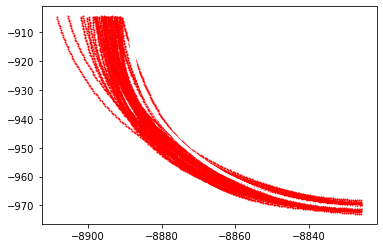

(-0.03928484821862926,
 0.026923090538032192,
 0.9555512281464509,
 0.19068066791544314)

In [11]:
right_delta_mn, right_delta_sd, right_t_scaling_mn, right_t_scaling_sd = create_sample(rights_upper)
right_delta_mn, right_delta_sd, right_t_scaling_mn, right_t_scaling_sd

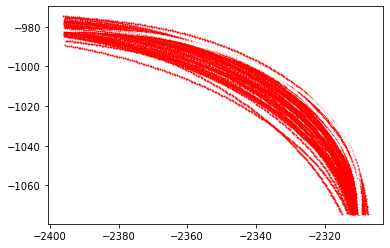

(-0.14057821493879752,
 0.10083848247029989,
 0.8880856023681836,
 0.13771364949769613)

In [12]:
left_delta_mn, left_delta_sd, left_t_scaling_mn, left_t_scaling_sd = create_sample(lefts_lower)
left_delta_mn, left_delta_sd, left_t_scaling_mn, left_t_scaling_sd

In [13]:
len(lefts_lower), len(lefts_upper), len(through_mid_up)

(45, 46, 49)

In [14]:
(left_delta_mn * len(lefts_lower) + right_delta_mn * len(rights_upper))/ (len(lefts_lower) + len(rights_upper)), (left_delta_sd * len(lefts_lower) + right_delta_sd * len(rights_upper))/ (len(lefts_lower) + len(rights_upper))

(-0.08883051672305939, 0.06307735833098922)

In [15]:
1-(left_t_scaling_mn * len(lefts_lower) + right_t_scaling_mn * len(rights_upper) + through_t_scaling_mn * len(through_mid_up))/ (len(lefts_lower) + len(rights_upper) + len(through_mid_up)), (left_t_scaling_sd * len(lefts_lower) + right_t_scaling_sd * len(rights_upper) + through_t_scaling_sd * len(through_mid_up))/ (len(lefts_lower) + len(rights_upper) + len(through_mid_up))

(0.07519752429797577, 0.14017874273029024)